In [83]:
print(__doc__)

# Common imports
import numpy as np
import numpy.random as rnd
import os
import pandas as pd

# To make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

Automatically created module for IPython interactive environment


In [9]:
#P(therapeutic) = 1 - [prob(lower than 60) + prob(higher than 100)]


# Load Data

In [30]:
csv_path = 'MIMIC II/ADMISSIONS.csv'
admissions = pd.read_csv(csv_path)
admissions.fillna('NoData', inplace = True)
admissions = admissions.applymap(str)

csv_path = 'MIMIC II/PATIENTS.csv'
patients = pd.read_csv(csv_path)
patients = patients.applymap(str)

In [31]:
admissions = admissions.drop(['ROW_ID', 'HADM_ID', 'DISCHTIME', 'ADMISSION_LOCATION', 'DIAGNOSIS', 'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG', 'DEATHTIME', 'ADMISSION_TYPE', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'HAS_CHARTEVENTS_DATA'], axis = 1)
patients = patients.drop(['ROW_ID', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN'], axis = 1)

In [32]:
# Convert the dates into weekdays
import datetime

admTime = admissions['ADMITTIME'].copy()

def get_day_of_week (value):
    date = []
    int_date = []
    day_of_week = []
    
    #replace dashes and colons with spaces to make breaking the string up easier
    value = value.replace('-', ' ')
    value = value.replace(':', ' ')
    
    #split into a string outputting [year, month, day, hour, minutes, seconds]
    date = value.split(' ')
    
    #delete hour/min/sec, convert to integers
    del date[3:6]
    int_date = [int(i) for i in date]
    
    #get day of week and return it
    day_of_week = datetime.date(int_date[0], int_date[1], int_date[2]).weekday()
    
    return day_of_week


admTime_weekday = [get_day_of_week(value) for value in admTime]

weekday_data = pd.DataFrame({'ADM_DAY' : admTime_weekday})
admissions = pd.concat([admissions, weekday_data], axis=1)
admissions = admissions.drop('ADMITTIME', axis = 1)
admissions = admissions.dropna()
admissions.head()

,SUBJECT_ID,ADM_DAY
0,22,5
1,23,0
2,23,1
3,24,5
4,25,6


In [47]:
fullData = pd.merge(admissions, patients, on = 'SUBJECT_ID')
fullData = fullData.drop('SUBJECT_ID', axis = 1)
fullData = fullData.applymap(str)
fullData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58976 entries, 0 to 58975
Data columns (total 3 columns):
ADM_DAY        58976 non-null object
GENDER         58976 non-null object
EXPIRE_FLAG    58976 non-null object
dtypes: object(3)
memory usage: 1.8+ MB


In [48]:
word_list = ['0', '1', '2', '3']
all_Wday = fullData[fullData['ADM_DAY'].str.contains('|'.join(word_list))]

word_list = ['M']
male_Wday = all_Wday[all_Wday['GENDER'].str.contains('|'.join(word_list))]

word_list = ['F']
female_Wday = all_Wday[all_Wday['GENDER'].str.contains('|'.join(word_list))]

word_list = ['4', '5', '6']
all_Wend = fullData[fullData['ADM_DAY'].str.contains('|'.join(word_list))]

word_list = ['M']
male_Wend = all_Wend[all_Wend['GENDER'].str.contains('|'.join(word_list))]

word_list = ['F']
female_Wend = all_Wend[all_Wend['GENDER'].str.contains('|'.join(word_list))]

# Working with Probabilities

In [78]:
def get_probability(data_array):
    mortality = data_array.sum()
    size = data_array.size
    probability = mortality / size
    return probability

# Weekday (all)
all_Wday_data = all_Wday['EXPIRE_FLAG'].copy().values.astype(int)
P_all_Wday = get_probability(all_Wday_data)
print('Probability that any ICU patient will die with a weekday admission: ', P_all_Wday)

# Weekday (male)
male_Wday_data = male_Wday['EXPIRE_FLAG'].copy().values.astype(int)
P_male_Wday = get_probability(male_Wday_data)
print('Probability that a male ICU patient will die with a weekday admission: ', P_male_Wday)

# Weekday (female)
female_Wday_data = female_Wday['EXPIRE_FLAG'].copy().values.astype(int)
P_female_Wday = get_probability(female_Wday_data)
print('Probability that a female ICU patient will die with a weekday admission: ', P_female_Wday)

# Weekend (all)
all_Wend_data = all_Wend['EXPIRE_FLAG'].copy().values.astype(int)
P_all_Wend = get_probability(all_Wend_data)
print('Probability that any ICU patient will die with a weekend admission: ', P_all_Wend)

# Weekend (male)
male_Wend_data = male_Wend['EXPIRE_FLAG'].copy().values.astype(int)
P_male_Wend = get_probability(male_Wend_data)
print('Probability that a male ICU patient will die with a weekend admission: ', P_male_Wend)

# Weekend (female)
female_Wend_data = female_Wend['EXPIRE_FLAG'].copy().values.astype(int)
P_female_Wend = get_probability(female_Wend_data)
print('Probability that a female ICU patient will die with a weekend admission: ', P_female_Wend)

Probability that any ICU patient will die with a weekday admission:  0.379337096386
Probability that a male ICU patient will die with a weekday admission:  0.371117192376
Probability that a female ICU patient will die with a weekday admission:  0.389681005317
Probability that any ICU patient will die with a weekend admission:  0.389256772401
Probability that a male ICU patient will die with a weekend admission:  0.381156670242
Probability that a female ICU patient will die with a weekend admission:  0.399620012666


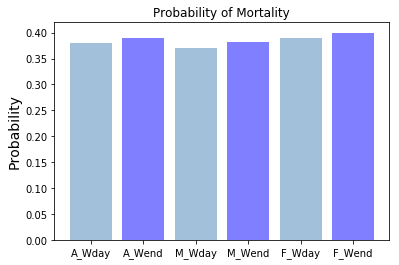

In [99]:
objects = ('A_Wday', 'A_Wend', 'M_Wday', 'M_Wend', 'F_Wday', 'F_Wend')
y_pos = np.arange(len(objects))
performance = [P_all_Wday, P_all_Wend, P_male_Wday,  P_male_Wend, P_female_Wday, P_female_Wend]
 
plt.bar(y_pos, performance, align='center', color = ['steelblue', 'blue'], alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Probability')
plt.title('Probability of Mortality')

plt.show()